## Chapter 1: exploratory data analysis of S&P500 daily close prices

**by Li Shen, Ph.D.**

**E-mail: shenli.sam@gmail.com**

**LinkedIn: https://www.linkedin.com/in/lshen**

**Updated: 2016/06/16**

## Summary

In this chapter, various statistical properties of the S&P500 daily close prices are explored, including stationarity, normality, linearity, heteroskedasticity and nonlinearity. The basic conclusions are: 1. the raw data are non-stationary while the log return data are stationary; 2. the log return data have fat tails and are modestly skewed; 3. the linear independency between the current log return and its lagged values cannot be rejected; 4. the log return data contain heteroskedasticity; 4. there is nonlinearity between the current log return and its lagged values.

### Load data and libraries

In [352]:
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Load SP500 daily closing prices from Jun 14 2001 to Jun 13 2016 from Yahoo finance (a 15 yr period).

In [353]:
import pandas_datareader.data as web
from datetime import datetime
sp500_daily = web.DataReader("^GSPC", "yahoo", datetime(1996, 6, 14), datetime(2016, 6, 13))

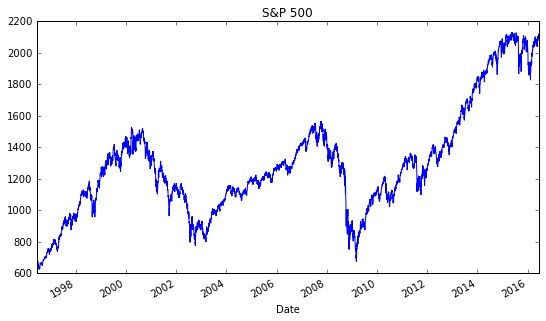

In [354]:
ts = sp500_daily['Adj Close']
ts.plot(figsize=[9, 5], title='S&P 500')

Looks like the SP500 index showed a sharp decline between 2008 and 2010 during the financial crisis and then has been climbing steadily since.

The purpose of this study is to forecast the S&P500 log returns. So here I calculate the log returns and use them across the board. In addition to its own lagged values, I'll also add the high-low range and the volume of the S&P500 as additional predictors. There are many options in features but here I just use them for simplicity. 

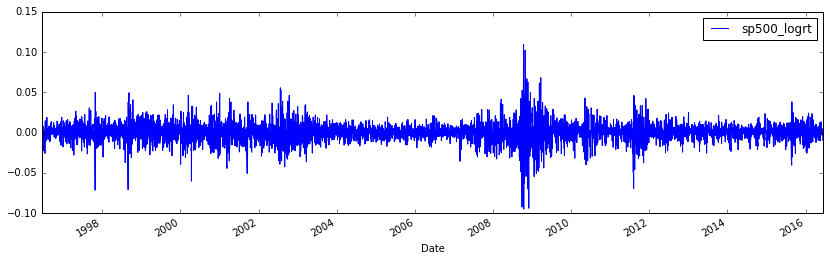

In [355]:
ts_logrt = pd.DataFrame(diff(log(ts)), index=ts.index[1:], columns=['sp500_logrt'])
ts_logrt.plot(figsize=(14, 4))

Clearly, the log return data displays volatility clustering and it is most volatile during the financial crisis.

Now, look at the high-low range data.

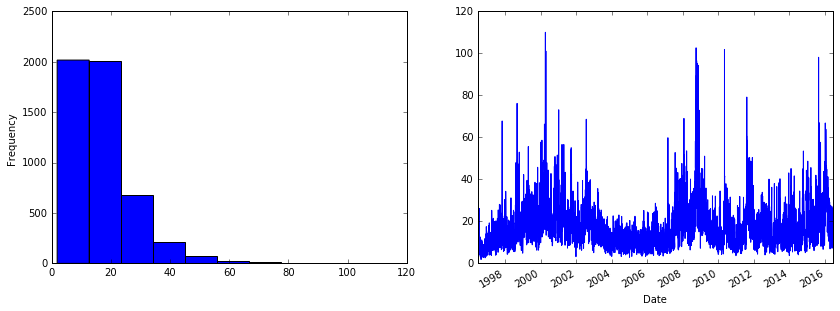

In [356]:
ts_range = sp500_daily['High'] - sp500_daily['Low']
ts_range = pd.DataFrame(ts_range.values, index=ts_range.index, 
                        columns=['hl_range'])
fig,axes = subplots(1, 2)
fig.set_size_inches([14, 5])
ts_range.plot(kind='hist', ax=axes[0], legend=False)
ts_range.plot(kind='line', ax=axes[1], legend=False)

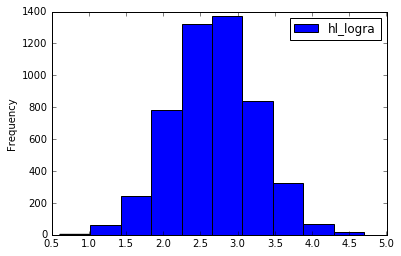

In [357]:
ts_logra = pd.DataFrame(log(ts_range.values), index=ts_range.index, columns=['hl_logra'])
ts_logra.plot(kind='hist')

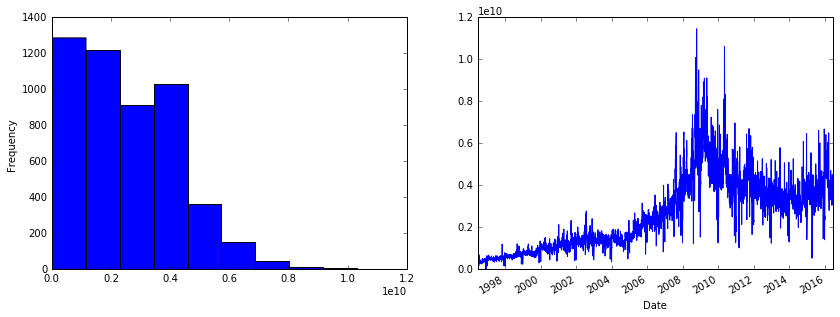

In [358]:
ts_volume = sp500_daily['Volume']
ts_volume = pd.DataFrame(ts_volume.values, index=ts_volume.index, 
                         columns=['volume'])
fig,axes = subplots(1, 2)
fig.set_size_inches([14, 5])
ts_volume.plot(kind='hist', ax=axes[0], legend=False)
ts_volume.plot(kind='line', ax=axes[1], legend=False)

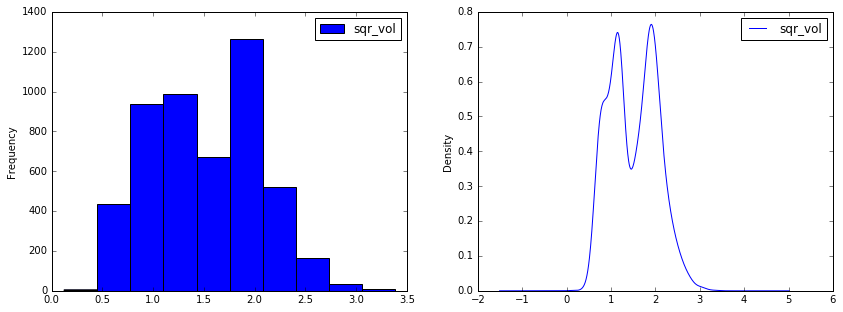

In [359]:
ts_sqrvol = pd.DataFrame(sqrt(ts_volume.values/1e9), index=ts_volume.index, 
                         columns=['sqr_vol'])
fig,axes = subplots(1, 2)
fig.set_size_inches([14, 5])
ts_sqrvol.plot(kind='hist', ax=axes[0])
ts_sqrvol.plot(kind='kde', ax=axes[1])

In [360]:
ts_logrtX = ts_logrt.merge(ts_logra, left_index=True, right_index=True)
ts_logrtX = ts_logrtX.merge(ts_sqrvol, left_index=True, right_index=True)
ts_logrtX.head()

,sp500_logrt,hl_logra,sqr_vol
Date,,,
1996-06-17,-0.001037,1.430310,0.546269
1996-06-18,-0.004671,1.613422,0.610975
1996-06-19,-0.000151,1.483869,0.619363
1996-06-20,0.000211,1.826164,0.664123
1996-06-21,0.007134,1.556048,0.721346


In [361]:
ts_logrtX.tail()

,sp500_logrt,hl_logra,sqr_vol
Date,,,
2016-06-07,0.001289,2.201663,1.880088
2016-06-08,0.003304,2.059250,1.887342
2016-06-09,-0.001719,2.293536,1.813924
2016-06-10,-0.009218,2.976045,1.874836
2016-06-13,-0.008148,2.978594,1.841746


Save the log return data to an external file for later use.

In [394]:
ts_logrtX.to_csv('ts_logrtX.csv')

### 1.1 Stationarity

The stationarity of a time series can be assessed with unit root tests. Here I will use three different tests on the raw S&P500 index and its log return series. They are: Augmented Dickey-Fuller (ADF) test, Phillips-Perron (PP) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. 

Based on the observation, there is no time trend in the log return series. There might be a small, positive drift. So I'll add a constant term to the tests.

In [363]:
from arch.unitroot import ADF, PhillipsPerron, KPSS
raw_adf = ADF(ts, trend='c')
lrt_adf = ADF(ts_logrt, trend='c')
raw_pp = PhillipsPerron(ts, trend='c')
lrt_pp = PhillipsPerron(ts_logrt, trend='c')
raw_kpss = KPSS(ts, trend='c')
lrt_kpss = KPSS(ts_logrt, trend='c')

In [364]:
stationarity_res = pd.DataFrame(index=['ADF', 'PP', 'KPSS'], 
                                columns=['Null hypothesis', 
                                         'raw.s', 'raw.p', 'lrt.s', 'lrt.p'])
stationarity_res.ix['ADF', 'Null hypothesis'] = 'Nonstationary'
stationarity_res.ix['ADF', 'raw.s'] = raw_adf.stat
stationarity_res.ix['ADF', 'raw.p'] = raw_adf.pvalue
stationarity_res.ix['ADF', 'lrt.s'] = lrt_adf.stat
stationarity_res.ix['ADF', 'lrt.p'] = lrt_adf.pvalue
##
stationarity_res.ix['PP', 'Null hypothesis'] = 'Nonstationary'
stationarity_res.ix['PP', 'raw.s'] = raw_pp.stat
stationarity_res.ix['PP', 'raw.p'] = raw_pp.pvalue
stationarity_res.ix['PP', 'lrt.s'] = lrt_pp.stat
stationarity_res.ix['PP', 'lrt.p'] = lrt_pp.pvalue
##
stationarity_res.ix['KPSS', 'Null hypothesis'] = 'Weakly stationary'
stationarity_res.ix['KPSS', 'raw.s'] = raw_kpss.stat
stationarity_res.ix['KPSS', 'raw.p'] = raw_kpss.pvalue
stationarity_res.ix['KPSS', 'lrt.s'] = lrt_kpss.stat
stationarity_res.ix['KPSS', 'lrt.p'] = lrt_kpss.pvalue
##
stationarity_res

,Null hypothesis,raw.s,raw.p,lrt.s,lrt.p
ADF,Nonstationary,-0.925349,0.77951,-16.187,4.20835e-29
PP,Nonstationary,-0.931763,0.777333,-76.5956,0
KPSS,Weakly stationary,7.16469,0.001,0.115898,0.513106


It can be seen that all three tests and in consistency and the conclusion is that the raw index series is nonstationary while the log return series is stationary.

### 1.2 Normality

The Jarque-Bera (JB) test is often used to test the normality of a sample. Here I'll use it to test the normality of the log return series.

In [365]:
from statsmodels.stats.stattools import jarque_bera
lrt_jb = jarque_bera(ts_logrt)

In [366]:
normality_res = pd.DataFrame(index=['Skewness', 'Kurtosis', 'JB stat', 'JB p-value'], 
                             columns=['Value'])
normality_res.ix['Skewness', 'Value'] = lrt_jb[2][0]
normality_res.ix['Kurtosis', 'Value'] = lrt_jb[3][0]
normality_res.ix['JB stat', 'Value'] = lrt_jb[0][0]
normality_res.ix['JB p-value', 'Value'] = lrt_jb[1][0]
normality_res

,Value
Skewness,-0.226697
Kurtosis,10.5963
JB stat,12141.5
JB p-value,0


It can be seen that the log return series is left skewed and has fat tails (the Kurtosis for a Normal distribution is 3). The JB test clearly rejects the null hypothesis that the log return series is normally distributed.

To gain some visual intuition of the data, I also use the Q-Q plot to compare the data with the normal distribution using the sample mean and sample standard deviation as parameters.

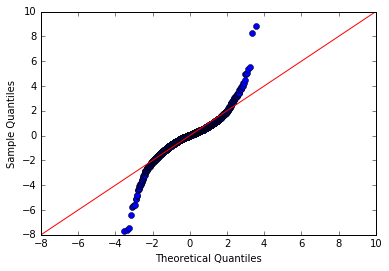

In [367]:
from statsmodels.graphics.gofplots import qqplot
fig, ax = subplots()
fig.set_size_inches([6, 4])
_ = qqplot(ts_logrt.values.ravel(), line='45', fit=True, ax=ax)

The Q-Q plot seems to correspond with the JB test result very well: at both lower and upper quantiles, the data significantly deviates from the normal distribution; The Q-Q plot has an "S" shape, indicating the data distribution has fat tails.

### 1.3 Linearity

Here I set out to test the linear independency of the log return series with its own lagged values. I'll perform the tests on both the log return series and the residuals from an ARMA model fit. This is to see if the ARMA fit can remove the linear dependency.

Also, I'll split the dataset into in-sample and out-sample from this point on.

In [368]:
# Split the log return series into in- and out-samples. 
# The split date is chosen to be a weekend with no value.
# This is simply for code brevity.
split_date = '2011-06-18'
lrt_train = ts_logrt[:split_date]
lrt_test = ts_logrt[split_date:]
print 'In-sample size:', lrt_train.shape
print 'Out-sample size:', lrt_test.shape

In-sample size: (3778, 1)
Out-sample size: (1254, 1)


In [369]:
# Use Durbin-Watson (DW) test for 1st order auto-correlation.
from statsmodels.stats.stattools import durbin_watson
lrt_train_dw = durbin_watson(lrt_train)
print "log return train set DW stat=", lrt_train_dw

log return train set DW stat= [ 2.13795489]


The DW statistic is larger than 2.0, which indicates the successive values have negative correlations (mean reversion). However, the DW test in the statsmodels package does not provide a p-value.

In [370]:
# Use Ljung-Box (LB) test for auto-correlation when jointly considering multiple lags.
from statsmodels.stats.diagnostic import acorr_ljungbox
lrt_train_lb = acorr_ljungbox(lrt_train, lags=20)
lrt_lb_res = pd.DataFrame(np.c_[lrt_train_lb[0], lrt_train_lb[1]], 
                          index=range(1, len(lrt_train_lb[0]) + 1), 
                          columns=['Stat', 'P-value'])
lrt_lb_res.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Stat,18.088973,3.397959e+01,3.701053e+01,3.734294e+01,4.169916e+01,4.171506e+01,4.626475e+01,4.732227e+01,4.732260e+01,5.027272e+01,5.447211e+01,6.557655e+01,6.655359e+01,6.823256e+01,7.334838e+01,8.093086e+01,8.102623e+01,8.775811e+01,8.933895e+01,9.018666e+01
P-value,0.000021,4.182412e-08,4.577828e-08,1.530808e-07,6.776534e-08,2.093001e-07,7.763828e-08,1.331015e-07,3.417282e-07,2.377858e-07,9.678921e-08,2.132591e-09,3.437461e-09,4.026177e-09,1.123746e-09,1.130321e-10,2.519294e-10,3.639121e-11,4.343120e-11,6.876137e-11


The LB test shows that we can reject the null hypothesis of linear independency of the log return series with its own lagged values. The p-values seem quite strong for all lag sizes from 1 to 20.

Now, I'll build an ARMA model for the log return series. This serves several purposes:
* To confirm the linear dependency of the series with its own lagged values.
* To create a baseline model for performance comparison with other machine learning methods.
* To use the residuals from the ARMA model fit for additional tests and model building.

#### 1.3.1 Automatic ARMA model selection

The *statsmodels* package contains a convenient function to automatically select the (p, q) order of an ARMA model. Using a high order can be computationally expensive. Therefore, I will set the maximum order at 5 for both AR and MA terms here.

In addition, the high-low range and volume data shall also be formatted to use as exogenous regressors. I use the maximum order as the lag size for ex data.

In [371]:
max_order = 5
lagged_lra = concatenate(
    map(lambda x: ts_logrtX.ix[range(x - 1, x - 1 - max_order, -1), 'hl_logra'], 
        range(max_order, ts_logrtX.shape[0]))
).reshape((-1, max_order))
lra_names = map(lambda x: 'R' + str(x), range(1, max_order + 1))
##
lagged_vol = concatenate(
    map(lambda x: ts_logrtX.ix[range(x - 1, x - 1 - max_order, -1), 'sqr_vol'], 
        range(max_order, ts_logrtX.shape[0]))
).reshape((-1, max_order))
vol_names = map(lambda x: 'V' + str(x), range(1, max_order + 1))
lagged_ex_df = pd.DataFrame(c_[lagged_lra, lagged_vol], 
                            index=ts_logrtX.index[max_order:], 
                            columns=concatenate([lra_names, vol_names]))
print 'Dimensions of lagged ex data:', lagged_ex_df.shape
lagged_ex_df.head(n=3)

Dimensions of lagged ex data: (5027, 10)


,R1,R2,R3,R4,R5,V1,V2,V3,V4,V5
Date,,,,,,,,,,
1996-06-24,1.556048,1.826164,1.483869,1.613422,1.430310,0.721346,0.664123,0.619363,0.610975,0.546269
1996-06-25,1.442197,1.556048,1.826164,1.483869,1.613422,0.577789,0.721346,0.664123,0.619363,0.610975
1996-06-26,1.211955,1.442197,1.556048,1.826164,1.483869,0.626019,0.577789,0.721346,0.664123,0.619363


In [372]:
lagged_ex_train = lagged_ex_df[:split_date]
lagged_ex_test = lagged_ex_df[split_date:]

In [373]:
from  statsmodels.tsa.stattools import arma_order_select_ic
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    arma_modsel_res = arma_order_select_ic(lrt_train[max_order:], 
                                           max_ar=max_order, max_ma=max_order, 
                                           ic='aic', trend='c', 
                                           model_kw={'exog': lagged_ex_train.values})

In [374]:
selected_order = arma_modsel_res['aic_min_order']
print 'Selected model (p, q) order based on AIC is:', selected_order
selected_order = (selected_order[0], 0, selected_order[1])

Selected model (p, q) order based on AIC is: (3, 3)


It selects an AR term order of 3 and an MA term order of 3. 

In [375]:
from statsmodels.tsa.arima_model import ARIMA
lrt_arma_mod = ARIMA(lrt_train[max_order:], selected_order, 
                     exog=lagged_ex_train)
lrt_arma_res = lrt_arma_mod.fit(trend='c')
print(lrt_arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:            sp500_logrt   No. Observations:                 3773
Model:                     ARMA(3, 3)   Log Likelihood               11028.816
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 15 Jun 2016   AIC                         -22021.633
Time:                        14:42:32   BIC                         -21909.392
Sample:                    06-24-1996   HQIC                        -21981.728
                         - 06-17-2011                                         
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0019      0.001      1.762      0.078        -0.000     0.004
R1                    0.0002      0.001      0.424      0.672        -0.001     0.001
R2                   -0.

The constant term also shows a small positive effect. This makes sense since the overall trend is increasing for S&P500. However, the range and the volume data do not show any significance in predicting the log returns. This does not exclude the possibility that they may contain nonlinearity with the log returns.

In [376]:
# I set up an ARMA model on the whole dataset so that the 
# prediction can take advantage of the info from the train
# set.
lrt_arma_tot = ARIMA(ts_logrt[max_order:], selected_order, 
                     exog=lagged_ex_df)
# The following fit call merely serves the purpose of setting up
# parameters. I do not intend to fit an ARMA model on the whole 
# dataset because the parameters are provided by the above trained 
# model already.
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        _ = lrt_arma_tot.fit(trend='c', maxiter=0, disp=-1)
    except ValueError:  # initial AR coefs may be non-stationary.
        pass
# Let the prediction start from the end of the train set, or the
# begin of the test set.
arma_test_pred = lrt_arma_tot.predict(lrt_arma_res.params, 
                                      start=len(lrt_train[max_order:]), 
                                      exog=lagged_ex_test)

In [395]:
arma_train_pred = lrt_arma_res.fittedvalues.values.ravel()
np.save('arma_train_pred.npy', arma_train_pred)
np.save('arma_test_pred.npy', arma_test_pred)

In [378]:
def r2_in_days(target, pred, n_days):
    '''Evaluate R2 scores in different days
    Args:
        target, pred (array-like): targets and predictions for evaluation.
        n_days: time horizon in number of days for evaluation.
    Returns: a list of R2 scores.
    '''
    from sklearn.metrics import r2_score
    r2s = []
    for d in n_days:
        if d == 'all':
            r2s.append(r2_score(target, pred))
        else:
            r2s.append(r2_score(target[:d], pred[:d]))
    return r2s

In [379]:
from sklearn.metrics import r2_score
r2_list = [r2_score(lrt_train[max_order:], arma_train_pred)]
r2_list.extend(r2_in_days(lrt_test, arma_test_pred, 
                          [30, 60, 120, 180, 300, 500, 'all']))
arma_r2_hrzn = pd.DataFrame(array(r2_list, ndmin=2), index=['ARMA R2'], 
                            columns=['Train', '30d', '60d', '120d', 
                                     '180d', '300d', '500d', 'all'])
arma_r2_hrzn

,Train,30d,60d,120d,180d,300d,500d,all
ARMA R2,0.013886,-0.022745,0.003483,0.002947,0.004131,0.003166,0.001828,-0.004528


Extract the residuals for further uses.

In [397]:
arma_train_resid = lrt_train[max_order:].values.ravel() - arma_train_pred
arma_test_resid = lrt_test.values.ravel() - arma_test_pred
arma_all_resid = concatenate((arma_train_resid, arma_test_resid))
np.save('arma_train_resid.npy', arma_train_resid)
np.save('arma_test_resid.npy', arma_test_resid)
np.save('arma_all_resid.npy', arma_all_resid)

Use Ljung-Box (LB) test on train residuals and add Breush-Godfrey LM test on the residuals too.

In [381]:
from statsmodels.stats.diagnostic import acorr_breush_godfrey
resid_train_lb = acorr_ljungbox(arma_train_resid, lags=20)
resid_train_lm = np.array(map(lambda lags: acorr_breush_godfrey(lrt_arma_res, lags), 
                              range(1, 21)))
resid_train_acorr = pd.DataFrame(np.c_[np.array(lrt_train_lb).T, 
                                       np.array(resid_train_lb).T, 
                                       resid_train_lm[:, :2]], 
                                 index=range(1, 21), 
                                 columns=['lrt.LB.s', 'lrt.LB.p', 
                                          'resid.LB.s', 'resid.LB.p', 
                                          'resid.LM.s', 'resid.LM.p'])

In [382]:
resid_train_acorr.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
lrt.LB.s,18.088973,3.397959e+01,3.701053e+01,3.734294e+01,4.169916e+01,4.171506e+01,4.626475e+01,4.732227e+01,4.732260e+01,5.027272e+01,5.447211e+01,6.557655e+01,6.655359e+01,6.823256e+01,7.334838e+01,8.093086e+01,8.102623e+01,8.775811e+01,8.933895e+01,9.018666e+01
lrt.LB.p,0.000021,4.182412e-08,4.577828e-08,1.530808e-07,6.776534e-08,2.093001e-07,7.763828e-08,1.331015e-07,3.417282e-07,2.377858e-07,9.678921e-08,2.132591e-09,3.437461e-09,4.026177e-09,1.123746e-09,1.130321e-10,2.519294e-10,3.639121e-11,4.343120e-11,6.876137e-11
resid.LB.s,0.057834,1.773658e-01,5.210982e-01,5.661027e-01,5.706078e-01,1.720430e+00,7.401618e+00,1.410930e+01,1.445915e+01,1.535404e+01,1.580856e+01,2.550274e+01,2.550285e+01,2.589673e+01,3.025439e+01,3.282451e+01,3.283379e+01,3.770453e+01,3.775896e+01,3.835103e+01
resid.LB.p,0.809953,9.151357e-01,9.142324e-01,9.667549e-01,9.893094e-01,9.435331e-01,3.882938e-01,7.896061e-02,1.069042e-01,1.196773e-01,1.483881e-01,1.261221e-02,1.980921e-02,2.668033e-02,1.103655e-02,7.795996e-03,1.183083e-02,4.237313e-03,6.368003e-03,8.020415e-03
resid.LM.s,0.120413,2.409824e-01,6.210979e-01,6.845123e-01,6.754063e-01,1.851221e+00,7.727449e+00,1.432183e+01,1.474389e+01,1.580081e+01,1.633951e+01,2.606084e+01,2.607379e+01,2.641491e+01,3.020523e+01,3.241274e+01,3.241283e+01,3.727269e+01,3.757369e+01,3.774787e+01
resid.LM.p,0.728587,8.864849e-01,8.915860e-01,9.532250e-01,9.842911e-01,9.328605e-01,3.572396e-01,7.375309e-02,9.821548e-02,1.054781e-01,1.289872e-01,1.052312e-02,1.661714e-02,2.291328e-02,1.120260e-02,8.832153e-03,1.336508e-02,4.828111e-03,6.721115e-03,9.504925e-03


It can be seen that after ARMA model fit, the auto-correlation is further removed from the series comparing the two LB test results. And LM test result confirms that the auto-correlation is non-existent.

### 1.4 Heteroskedasticity

As shown above, the log return series displays volatility clustering. Conditional heteroskedasticity is a common phenomenon in financial time series, which is the source of the data's non-normality. First, I'll test its existence using the LB test on the squared residuals from ARMA fit.

In [383]:
res2_train_lb = acorr_ljungbox(arma_train_resid**2, lags=20)
res2_lb_res = pd.DataFrame(np.c_[res2_train_lb[0], res2_train_lb[1]], 
                           index=range(1, len(res2_train_lb[0]) + 1), 
                           columns=['Stat', 'P-value'])
res2_lb_res.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Stat,1.283414e+02,6.042588e+02,7.285295e+02,1.045971e+03,1.429630e+03,1751.073446,2095.561383,2291.997532,2576.198307,2809.691628,3240.424705,3515.307261,3683.875278,3754.872349,3928.213046,4155.098237,4401.705561,4582.387084,4697.497495,4858.442322
P-value,9.450646e-30,6.121760e-132,1.366420e-157,3.887735e-225,5.227264e-307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The result at all lags rejects the null hypothesis that there is no auto-correlation in the squared residuals at the significance level of 0.05, indicating the existence of conditional heteroskedasticity.

**NOT DONE: Other tests for heteroskedasticity:**

from `lmtest`:

"the Breusch-Pagan test fits a linear regression model to the residuals and rejects if too much of the variance is explained by the auxiliary explanatory variables, which are here the squared lagged values.

Whereas the Breusch-Pagan test and the Harrison-McCabe test do not assume a particular timing of the change of variance, the Goldfeld-Quandt test suffers from the same problem as the Chow test for a change of the regression coefficients: the breakpoint has to be known in advance."

#### 1.4.1 GARCH(1, 1) model

In [384]:
from arch.univariate import arch_model
arma_resid_am = arch_model(arma_train_resid, #mean='Zero', 
                           vol='Garch', p=1, q=1)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    arma_resid_am_res = arma_resid_am.fit(update_freq=0, disp='off', cov_type='robust')
arma_resid_am_res.summary()

/Users/lishen/anaconda/lib/python2.7/site-packages/arch/univariate/base.py:519: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                11734.8
Distribution:                  Normal   AIC:                          -23461.6
Method:            Maximum Likelihood   BIC:                          -23436.7
                                        No. Observations:                 3773
Date:                Wed, Jun 15 2016   Df Residuals:                     3769
Time:                        14:42:35   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu         3.2104e-04  9.405e-05      3.414  6.413e-04   [1.367e-04,5.054e-04]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      3.3854e-06  8.175e-13  4.141e+06      0.000   [3.385e-06,3.385e-06]
alpha[1]       0.1000  1.101e-02      9.080  1.082e-19     [7.842e-02,  0.122]
beta[1]        0.8800  8.674e-03    101.451      0.000       [  0.863,  0.897]
==============================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate sucessful convergence. The message was
Positive directional derivative for linesearch. See convergence_flag.
"""

Despite the warning about the convergence, the GARCH(1,1) model fit indicates a strong effect of the 1st order auto-regressive term. 

**TODO**: redo LB and maybe LM tests on the GARCH residuals. The *arch* package does not provide a function to retrieve GARCH residuals: the member *resid* contains the residuals of the mean model.

### 1.5 Nonlinearity

#### 1.5.1 BDS test

In [385]:
from rpy2.robjects.packages import importr
tseries = importr('tseries')

In [386]:
from rpy2 import robjects
r_arma_resid = robjects.FloatVector(arma_train_resid)
bds_res = tseries.bds_test(r_arma_resid, m=5)

In [387]:
print bds_res.rx('statistic')
print bds_res.rx('p.value')
#print bds_res.rx('parameter')

$statistic
  0.00650589301415897 0.0130117860283179 0.0195176790424769 0.0260235720566359
2             7.57694           8.828127           11.23258           13.39313
3            13.06244          14.060709           15.79910           17.57444
4            17.56994          17.825231           18.95258           20.29927
5            22.65865          21.702631           21.84572           22.37218


$p.value
  0.00650589301415897 0.0130117860283179 0.0195176790424769 0.0260235720566359
2        3.538016e-14       1.064432e-18       2.821160e-29       6.632690e-41
3        5.396707e-39       6.621965e-45       3.155858e-56       3.867057e-69
4        4.186371e-69       4.502273e-71       4.204305e-80       1.305007e-91
5       1.146509e-113      1.937533e-104      8.536019e-106      7.345099e-111




Clearly, the BDS test rejects the null hypothesis that the residuals are i.i.d. and there are nonlinear structures remaining in the residuals of the ARMA fit. However, the BDS test does not tell us what sort of nonlinearity is there.

#### 1.5.2 Harvey-Collier test

In [388]:
from statsmodels.stats.diagnostic import linear_harvey_collier
hctest_res = linear_harvey_collier(lrt_arma_res)
print 'Statistic: %.2f, P-value: %.2f' % (hctest_res.statistic, hctest_res.pvalue)

Statistic: nan, P-value: nan


Harvey-Collier test does not reject its null hypothesis, which means the nonlinearity is not convex (or concave).

#### 1.5.3 Teraesvirta Neural Network Test

In [389]:
stats = importr('stats')
rts_lrt_train = stats.as_ts(robjects.FloatVector(lrt_train.values.ravel()))
lag_list = [1, 2, 5, 10, 15, 20]
ttype_list = ['Chisq', 'F']
tera_res = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.terasvirta_test(rts_lrt_train, lag=lag, type=ttype)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        tera_res.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)

In [390]:
tera_res

,1,2,5,10,15,20
Chisq,"33.37, 5.66E-08","72.04, 5.70E-13","324.69, 0.00E+00","1336.83, 0.00E+00","2614.71, 0.00E+00","4941.06, 0.00E+00"
F,"16.75, 5.74E-08","10.37, 6.04E-13","6.68, 0.00E+00","5.39, 0.00E+00","3.70, 0.00E+00","3.10, 0.00E+00"


The Teraesvirta NN test suggests that at large lag size (>=5), the linearity hypothesis can be rejected and there exists nonlinearity in the log return series.

#### 1.5.4 White Neural Network Test

The White NN test seems to be a fancier version of the NN test than the Teraesvirta test with extra parameters that control the # of phantom hidden units and the # of PCs. 

In [391]:
white_res = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res

,1,2,5,10,15,20
Chisq,"22.18, 1.52E-05","25.90, 2.37E-06","9.91, 7.04E-03","2.63, 2.69E-01","0.04, 9.79E-01","4.95, 8.41E-02"
F,"7.46, 5.85E-04","16.69, 6.07E-08","3.63, 2.67E-02","0.24, 7.87E-01","5.85, 2.92E-03","1.32, 2.69E-01"


In [392]:
white_res2 = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype, q=20, qstar=4)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res2.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res2

,1,2,5,10,15,20
Chisq,"22.57, 1.54E-04","42.09, 1.60E-08","43.56, 7.92E-09","8.63, 7.11E-02","10.85, 2.83E-02","12.97, 1.14E-02"
F,"8.23, 1.31E-06","9.21, 2.12E-07","6.79, 1.92E-05","3.86, 3.93E-03","4.70, 8.71E-04","0.42, 7.93E-01"


In [393]:
white_res3 = pd.DataFrame(index=ttype_list, columns=lag_list)
for lag in lag_list:
    for ttype in ttype_list:
        res = tseries.white_test(rts_lrt_train, lag=lag, type=ttype, q=5, qstar=2)
        s = res.rx('statistic')[0][0]
        p = res.rx('p.value')[0][0]
        white_res3.ix[ttype, lag] = "%.2f" % (s) + ", " + "%.2E" % (p)
white_res3

,1,2,5,10,15,20
Chisq,"10.75, 4.63E-03","2.33, 3.12E-01","9.29, 9.59E-03","12.75, 1.71E-03","5.41, 6.68E-02","2.52, 2.83E-01"
F,"9.21, 1.02E-04","13.07, 2.21E-06","5.96, 2.60E-03","2.27, 1.03E-01","3.18, 4.19E-02","0.24, 7.84E-01"


With varied # of hidden units and PCs, the null hypothesis of linearity is not rejected by the White NN test.